In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob, os, re

import scipy.signal as sgn
import scipy.integrate as scint
import statsmodels.api as sm
import numpy.linalg as la

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
folder = '/content/drive/My Drive/UFMG - projetos/Alice Campolina - caminhada/Coleta de dados/Coletas realizadas/'
plots_folder = '/content/drive/My Drive/UFMG - projetos/Alice Campolina - caminhada/'

Mounted at /content/drive/


In [ ]:
def find_columns(T):
  str_find = [r'peE.+?Acc.+?X',r'peE.+?Acc.+?Y',r'peE.+?Acc.+?Z',
              r'peE.+?Gyro.+?X',r'peE.+?Gyro.+?Y',r'peE.+?Gyro.+?Z',
              r'peD.+?Acc.+?X',r'peD.+?Acc.+?Y',r'peD.+?Acc.+?Z',
              r'peD.+?Gyro.+?X',r'peD.+?Gyro.+?Y',r'peD.+?Gyro.+?Z']

  cols = []
  for sf in str_find:
    r = re.compile(sf)
    for ivar, var in enumerate(list(T.columns)):
      if r.search(var):
        # print(ivar,var)
        cols += [ivar]
        break
  return cols

In [ ]:
def find_columns_acc(T):
  str_find = [r'peE.+?Acc.+?X',r'peE.+?Acc.+?Y',r'peE.+?Acc.+?Z',
              r'peD.+?Acc.+?X',r'peD.+?Acc.+?Y',r'peD.+?Acc.+?Z']

  cols = []
  for sf in str_find:
    r = re.compile(sf)
    for ivar, var in enumerate(list(T.columns)):
      if r.search(var):
        # print(ivar,var)
        cols += [ivar]
        break
  return cols

In [ ]:
def find_columns_acc_pelve(T):
  str_find = [r'pelve.+?Acc.+?X',r'pelve.+?Acc.+?Y',r'pelve.+?Acc.+?Z']

  cols = []
  for sf in str_find:
    r = re.compile(sf)
    for ivar, var in enumerate(list(T.columns)):
      if r.search(var):
        # print(ivar,var)
        cols += [ivar]
        break
  return cols

In [ ]:
def steps_time(T,cols):
  t = T.iloc[:,0].to_numpy()
  dt = np.mean(np.diff(t))

  peE = T.iloc[:,cols[:3]].to_numpy()
  peD = T.iloc[:,cols[6:9]].to_numpy()

  mpeE = np.linalg.norm(peE,axis=1)
  mpeD = np.linalg.norm(peD,axis=1)

  intE = np.cumsum(mpeE)*dt
  intD = np.cumsum(mpeD)*dt

  peaksE,_ = sgn.find_peaks(mpeE,height=0.75*np.max(mpeE),distance=10)
  peaksD,_ = sgn.find_peaks(mpeD,height=0.75*np.max(mpeD),distance=10)

  totalE = intE[-1]
  totalD = intD[-1]

  streckE = intE[peaksE]
  streckD = intD[peaksD]

  dE = np.mean(np.diff(streckE))
  dD = np.mean(np.diff(streckD))

  n = 1.0*(len(streckE)+len(streckD))
  print(n)
  if n<20:
    n = 20

  step_time = (dE*0.5+dD*0.5)*20/n

  return step_time

In [ ]:
def rms_acc(T,cols):
  t = T.iloc[:,0].to_numpy()
  dt = np.mean(np.diff(t))

  peE = T.iloc[:,cols[:3]].to_numpy()
  peD = T.iloc[:,cols[3:]].to_numpy()

  mpeE = np.std(np.linalg.norm(peE,axis=1))
  mpeD = np.std(np.linalg.norm(peD,axis=1))
  mpe = 0.5*mpeE+0.5*mpeD

  return mpe

In [ ]:
def contact_both(T,cols):
  t = T.iloc[:,0].to_numpy()
  dt = np.mean(np.diff(t))

  try:
    peE = T.iloc[:,cols[:3]].to_numpy()
    peD = T.iloc[:,cols[3:]].to_numpy()

    peEz = peE[:,2]
    peDz = peD[:,2]

    peaksE,_ = sgn.find_peaks(peEz,height=0.75*np.max(peEz),distance=10)
    peaksD,_ = sgn.find_peaks(peDz,height=0.75*np.max(peDz),distance=10)

    v1 = peaksE
    v2 = peaksD
    dd = np.rint(np.mean(np.diff(v1)))*0.8
    md = 0
    k = 0
    if len(v1)>0 and len(v2)>0:
      for i in v1:
        e = np.abs(i-v2)
        j = np.argmin(e)
        if e[j]<dd:
          md += e[j]
          k += 1
      md /= k
    else:
      md = 0

    return md*dt
  except:
    return 0

In [ ]:
def steps_length(T,cols):
  t = T.iloc[:,0].to_numpy()
  dt = np.mean(np.diff(t))

  peE = T.iloc[:,cols[:3]].to_numpy()
  peD = T.iloc[:,cols[6:9]].to_numpy()

  mpeE = np.linalg.norm(peE,axis=1)
  mpeD = np.linalg.norm(peD,axis=1)

  intE = np.cumsum(mpeE)*dt
  intD = np.cumsum(mpeD)*dt

  peaksE,_ = sgn.find_peaks(mpeE,height=0.75*np.max(mpeE),distance=10)
  peaksD,_ = sgn.find_peaks(mpeD,height=0.75*np.max(mpeD),distance=10)

  totalE = intE[-1]
  totalD = intD[-1]

  streckE = intE[peaksE]
  streckD = intD[peaksD]

  dE = np.mean(np.diff(streckE))
  dD = np.mean(np.diff(streckD))

  n = 1.0*(len(streckE)+len(streckD))
  if n<20:
    n = 20

  step_length = np.mean(10*(dE*0.5+dD*0.5)/totalE)*20/n

  return step_length

In [ ]:
def reject_outliers(data, m=2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

In [ ]:
def step_time_average(T, cols):

  t = T.iloc[:,0].to_numpy()

  peE = T.iloc[:,cols[:3]].to_numpy()
  peD = T.iloc[:,cols[3:]].to_numpy()

  mpeE = la.norm(peE,axis=1)
  mpeD = la.norm(peD,axis=1)

  b,a = sgn.butter(8,0.15)
  mpeE = sgn.filtfilt(b,a,mpeE)
  mpeD = sgn.filtfilt(b,a,mpeD)

  N = 10#int(0.05*len(t))
  ta = t[N:-N]
  mpeE = mpeE[N:-N]
  mpeD = mpeD[N:-N]

  N = 10
  acE = np.correlate(mpeE,mpeE,mode='full')
  acD = np.correlate(mpeD,mpeD,mode='full')
  acE = acE[:len(acE)//2]
  acE = acE[N:-N]
  acD = acD[:len(acD)//2]
  acD = acD[N:-N]

  peaksD, _ = sgn.find_peaks(acD,prominence=30,distance=70)
  peaksE, _ = sgn.find_peaks(acE,prominence=30,distance=70)

  steps = np.concatenate((np.diff(t[peaksD]), np.diff(t[peaksE])))
  ns = len(steps)+1
  steps = reject_outliers(steps)
  st = np.mean(steps)
  print(ns)

  if len(peaksD)>1 and len(peaksE)>1:
    dTD = 10*(t[peaksD[-1]]-t[peaksD[0]])/(ns*(t[-1]-t[0]))
    dTE = 10*(t[peaksE[-1]]-t[peaksE[0]])/(ns*(t[-1]-t[0]))
    sl = 0.5*dTD + 0.5*dTE
  elif len(peaksD)>1:
    dTD = 10*(t[peaksD[-1]]-t[peaksD[0]])/(ns*(t[-1]-t[0]))
    sl = dTD
  elif len(peaksE)>1:
    dTE = 10*(t[peaksE[-1]]-t[peaksE[0]])/(ns*(t[-1]-t[0]))
    sl = dTE
  else:
    sl = 0

  return st, sl

In [ ]:
vgroups = []
vcond = []
vpart = []
vsteptime = []
vsteplength = []
vspeed = []
vacc = []
vacc_pelve = []
ct = []


errors = []

groups = ['Idosos','Jovens']
conditions = ['N','NC','NFE','NFI','R','RC','RFE','RFI']
for g in groups:
  for cond in conditions:
    if g=='Idosos':
      parts = range(101,143)
    else:
      parts = range(1,43)

    for part in parts:
      files = glob.glob(plots_folder+'Coleta de dados/Coletas realizadas/'+g+
                        '/*/'+'{:02}'.format(part)+'*'+cond+'.xlsx')
      print(g+' '+cond+' '+'Participantes',len(files))
      if len(files) == 1:
        f = files[0]

        T = pd.read_excel(f)
        cols = find_columns(T)
        cols_acc = find_columns_acc(T)
        cols_acc_pelve = find_columns_acc_pelve(T)

        vgroups += [g]
        vcond += [cond]
        vpart += [str(part)]
        st,sl = step_time_average(T,cols_acc)
        vsteptime += [st]
        #sl = steps_length(T,cols)
        vsteplength += [sl]
        vspeed += [sl/st]
        al = rms_acc(T,cols_acc)
        vacc += [al]
        al = rms_acc(T,cols_acc_pelve)
        vacc_pelve += [al]
        ct += [contact_both(T,cols_acc)]

        if np.isnan(st) or np.isnan(sl):
          errors += [(g,cond,part,f)]

      else:
        print(files)
        print('Coleta de dados/Coletas realizadas/'+g+
              '/*/'+'{:02}'.format(part)+'*'+cond+'.xlsx')
        vgroups += [g]
        vcond += [cond]
        vpart += [str(part)]
        st = 0
        vsteptime += [st]
        sl = 0
        vsteplength += [sl]
        vspeed += [0]
        vacc += [0]
        vacc_pelve += [0]
        ct += [0]


results = pd.DataFrame({'group':vgroups,
                        'participant':vpart,
                        'condition':vcond,
                        'step_time':vsteptime,
                        'step_length':vsteplength,
                        'step_speed':vspeed,
                        'rms_acc':vacc,
                        'rms_acc_pelve':vacc_pelve,
                        'both_contact_time': ct})



Idosos N Participantes 1
15
Idosos N Participantes 1
13
Idosos N Participantes 1
14
Idosos N Participantes 1
10
Idosos N Participantes 1


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


1
Idosos N Participantes 1
13
Idosos N Participantes 1
15
Idosos N Participantes 1
13
Idosos N Participantes 1
14
Idosos N Participantes 1
16
Idosos N Participantes 1
11
Idosos N Participantes 1
13
Idosos N Participantes 1
13
Idosos N Participantes 1
11
Idosos N Participantes 1
13
Idosos N Participantes 1
11
Idosos N Participantes 1
14
Idosos N Participantes 1
14
Idosos N Participantes 1
14
Idosos N Participantes 1
19
Idosos N Participantes 1
10
Idosos N Participantes 1
15
Idosos N Participantes 1
13
Idosos N Participantes 1
11
Idosos N Participantes 1
20
Idosos N Participantes 1
14
Idosos N Participantes 1
12
Idosos N Participantes 1
12
Idosos N Participantes 1
15
Idosos N Participantes 1
13
Idosos N Participantes 1
6
Idosos N Participantes 1
10
Idosos N Participantes 1
14
Idosos N Participantes 1
13
Idosos N Participantes 1
11
Idosos N Participantes 1
12
Idosos N Participantes 1
12
Idosos N Participantes 1
11
Idosos N Participantes 1
15
Idosos N Participantes 1


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


16
Idosos N Participantes 1
13
Idosos N Participantes 1
11
Idosos NC Participantes 1
17
Idosos NC Participantes 1
18
Idosos NC Participantes 1
14
Idosos NC Participantes 1
14
Idosos NC Participantes 1
13
Idosos NC Participantes 1
13
Idosos NC Participantes 1
14
Idosos NC Participantes 1
13
Idosos NC Participantes 1
11
Idosos NC Participantes 1
16
Idosos NC Participantes 1
13
Idosos NC Participantes 1
9
Idosos NC Participantes 1
14
Idosos NC Participantes 1
12
Idosos NC Participantes 1
14
Idosos NC Participantes 0
[]
Coleta de dados/Coletas realizadas/Idosos/*/116*NC.xlsx
Idosos NC Participantes 1
15
Idosos NC Participantes 1
14
Idosos NC Participantes 1
13
Idosos NC Participantes 1
17
Idosos NC Participantes 1
12
Idosos NC Participantes 1
14
Idosos NC Participantes 1
14
Idosos NC Participantes 1
12
Idosos NC Participantes 1
18
Idosos NC Participantes 1
15
Idosos NC Participantes 1
13
Idosos NC Participantes 1
14
Idosos NC Participantes 1
14
Idosos NC Participantes 1
15
Idosos NC Partic

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


15
Idosos NFI Participantes 1
17
Idosos NFI Participantes 1
5
Idosos NFI Participantes 1
5
Idosos R Participantes 1
14
Idosos R Participantes 1
15
Idosos R Participantes 1
12
Idosos R Participantes 1
16
Idosos R Participantes 1
12
Idosos R Participantes 1
9
Idosos R Participantes 1
11
Idosos R Participantes 1
11
Idosos R Participantes 1
12
Idosos R Participantes 1
13
Idosos R Participantes 1
15
Idosos R Participantes 1
9
Idosos R Participantes 1


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


14
Idosos R Participantes 1
11
Idosos R Participantes 1
12
Idosos R Participantes 1
12
Idosos R Participantes 1
15
Idosos R Participantes 1
12
Idosos R Participantes 1
14
Idosos R Participantes 1
13
Idosos R Participantes 1
7
Idosos R Participantes 1
13
Idosos R Participantes 1
13
Idosos R Participantes 1
13
Idosos R Participantes 1
22
Idosos R Participantes 1
12
Idosos R Participantes 1


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


13
Idosos R Participantes 1
13
Idosos R Participantes 1
13
Idosos R Participantes 1
14
Idosos R Participantes 1
15
Idosos R Participantes 1
9
Idosos R Participantes 1
12
Idosos R Participantes 1
15
Idosos R Participantes 1
15
Idosos R Participantes 1
11
Idosos R Participantes 1
14
Idosos R Participantes 1
12
Idosos R Participantes 1
11
Idosos R Participantes 1
16
Idosos R Participantes 1
13
Idosos R Participantes 1
9
Idosos RC Participantes 1
16
Idosos RC Participantes 1
12
Idosos RC Participantes 1
13
Idosos RC Participantes 1
15
Idosos RC Participantes 1
12
Idosos RC Participantes 1
11
Idosos RC Participantes 1
12
Idosos RC Participantes 1
12
Idosos RC Participantes 1
13
Idosos RC Participantes 1
16
Idosos RC Participantes 1
15
Idosos RC Participantes 1
9
Idosos RC Participantes 1
17
Idosos RC Participantes 1
11
Idosos RC Participantes 1
13
Idosos RC Participantes 1
11
Idosos RC Participantes 1
17
Idosos RC Participantes 1
13
Idosos RC Participantes 1
13
Idosos RC Participantes 1
12


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


12
Jovens NFI Participantes 1
13
Jovens NFI Participantes 1
11
Jovens NFI Participantes 1
15
Jovens NFI Participantes 1
11
Jovens NFI Participantes 1
10
Jovens NFI Participantes 1
10
Jovens NFI Participantes 1
13
Jovens NFI Participantes 1
13
Jovens NFI Participantes 1
11
Jovens NFI Participantes 1
11
Jovens NFI Participantes 1
12
Jovens NFI Participantes 1
12
Jovens NFI Participantes 1
10
Jovens NFI Participantes 1
14
Jovens NFI Participantes 1
8
Jovens NFI Participantes 1
14
Jovens NFI Participantes 1
13
Jovens NFI Participantes 1
12
Jovens NFI Participantes 1
12
Jovens NFI Participantes 1
13
Jovens NFI Participantes 1
9
Jovens NFI Participantes 1
12
Jovens NFI Participantes 1
9
Jovens NFI Participantes 1
13
Jovens NFI Participantes 1
10
Jovens NFI Participantes 1
12
Jovens NFI Participantes 1
11
Jovens NFI Participantes 1
13
Jovens NFI Participantes 1
10
Jovens NFI Participantes 1
12
Jovens NFI Participantes 1
13
Jovens NFI Participantes 1
8
Jovens NFI Participantes 1
15
Jovens NFI 

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,


1
Jovens R Participantes 1
6
Jovens R Participantes 1
9
Jovens R Participantes 1
11
Jovens R Participantes 1
8
Jovens R Participantes 1
5
Jovens R Participantes 1
11
Jovens R Participantes 1
10
Jovens R Participantes 1
10
Jovens R Participantes 1
11
Jovens R Participantes 1
9
Jovens R Participantes 1
10
Jovens R Participantes 1
9
Jovens R Participantes 1
9
Jovens R Participantes 1


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


11
Jovens R Participantes 1
8
Jovens R Participantes 1
12
Jovens R Participantes 1
11
Jovens R Participantes 1
10
Jovens R Participantes 1
8
Jovens R Participantes 1
11
Jovens R Participantes 1
9
Jovens R Participantes 1
8
Jovens R Participantes 1
11
Jovens R Participantes 1
7
Jovens R Participantes 1
8
Jovens R Participantes 1
10
Jovens R Participantes 1
7
Jovens R Participantes 1
12
Jovens R Participantes 1
9
Jovens R Participantes 1
7
Jovens R Participantes 1
11
Jovens R Participantes 1
11
Jovens R Participantes 1
10
Jovens R Participantes 1
11
Jovens R Participantes 1
9
Jovens R Participantes 1
7
Jovens R Participantes 1
13
Jovens R Participantes 1
13
Jovens RC Participantes 1
12
Jovens RC Participantes 1
10
Jovens RC Participantes 1
8
Jovens RC Participantes 1


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


1
Jovens RC Participantes 1
9
Jovens RC Participantes 1
11
Jovens RC Participantes 1
13
Jovens RC Participantes 1
8
Jovens RC Participantes 1
10
Jovens RC Participantes 1
11
Jovens RC Participantes 1
12
Jovens RC Participantes 1
12
Jovens RC Participantes 1
12
Jovens RC Participantes 1
10
Jovens RC Participantes 1
11
Jovens RC Participantes 1
9
Jovens RC Participantes 1
9
Jovens RC Participantes 1
11
Jovens RC Participantes 1
14
Jovens RC Participantes 1
11
Jovens RC Participantes 1
10
Jovens RC Participantes 1
11
Jovens RC Participantes 1
10
Jovens RC Participantes 1
11
Jovens RC Participantes 1
13
Jovens RC Participantes 1
7
Jovens RC Participantes 1
9
Jovens RC Participantes 1
8
Jovens RC Participantes 1
9
Jovens RC Participantes 1
11
Jovens RC Participantes 1
13
Jovens RC Participantes 1
11
Jovens RC Participantes 1
12
Jovens RC Participantes 1
9
Jovens RC Participantes 1
9
Jovens RC Participantes 1
13
Jovens RC Participantes 1
13
Jovens RC Participantes 1
13
Jovens RC Participante

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


12
Jovens RFE Participantes 1
14
Jovens RFE Participantes 1
12
Jovens RFE Participantes 1
10
Jovens RFE Participantes 1
12
Jovens RFE Participantes 1
12
Jovens RFE Participantes 1
13
Jovens RFE Participantes 1
11
Jovens RFE Participantes 1
11
Jovens RFE Participantes 1
11
Jovens RFE Participantes 1
8
Jovens RFE Participantes 1
11
Jovens RFE Participantes 1
11
Jovens RFE Participantes 1
13
Jovens RFE Participantes 1
12
Jovens RFE Participantes 1
10
Jovens RFE Participantes 1
11
Jovens RFE Participantes 1
12
Jovens RFE Participantes 1
13
Jovens RFE Participantes 1
13
Jovens RFE Participantes 1
10
Jovens RFE Participantes 1
10
Jovens RFE Participantes 1
11
Jovens RFE Participantes 1
11
Jovens RFE Participantes 1
11
Jovens RFI Participantes 1
13
Jovens RFI Participantes 1
11
Jovens RFI Participantes 1
8
Jovens RFI Participantes 1
5
Jovens RFI Participantes 1
9
Jovens RFI Participantes 1
11
Jovens RFI Participantes 1
13
Jovens RFI Participantes 1
8
Jovens RFI Participantes 1
9
Jovens RFI Pa

In [ ]:
results

,group,participant,condition,step_time,step_length,step_speed,rms_acc,rms_acc_pelve,both_contact_time
0,Idosos,101,N,1.001875,0.532205,0.531209,1.279747,0.257058,0.027500
1,Idosos,102,N,1.206000,0.446642,0.370350,0.703035,0.251822,0.132500
2,Idosos,103,N,1.037727,0.590619,0.569147,1.395064,0.139825,0.427500
3,Idosos,104,N,1.255833,0.470056,0.374298,0.793841,0.054484,0.160500
4,Idosos,105,N,NaN,0.000000,NaN,0.434274,0.234616,0.090938
...,...,...,...,...,...,...,...,...,...
667,Jovens,38,RFI,1.007500,0.630264,0.625573,1.108586,0.266702,0.098750
668,Jovens,39,RFI,0.922500,0.726141,0.787145,1.589073,0.190699,0.088500
669,Jovens,40,RFI,0.761250,0.717517,0.942551,1.937815,0.202539,0.140625
670,Jovens,41,RFI,0.887727,0.576469,0.649376,1.433548,0.173375,0.098571


In [ ]:
results.to_excel(plots_folder+'Step_results.xlsx')

In [ ]:
resultss = pd.read_excel(plots_folder+'Step_results.xlsx')
results_pivot = resultss.pivot(index = ['group','participant'],
                               columns='condition',
                               values=['step_time','step_length','step_speed',
                                       'rms_acc', 'rms_acc_pelve', 'both_contact_time'])
results_pivot.to_excel(plots_folder+'Step_results_pivot_.xlsx')

# Estatística

In [ ]:
import seaborn as sns

In [ ]:
results = resultss.drop('Unnamed: 0',axis=1)

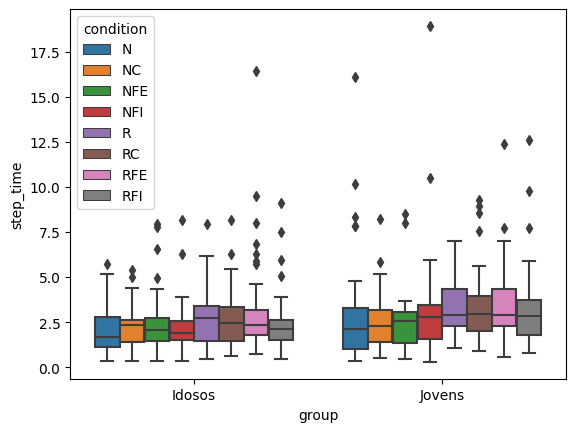

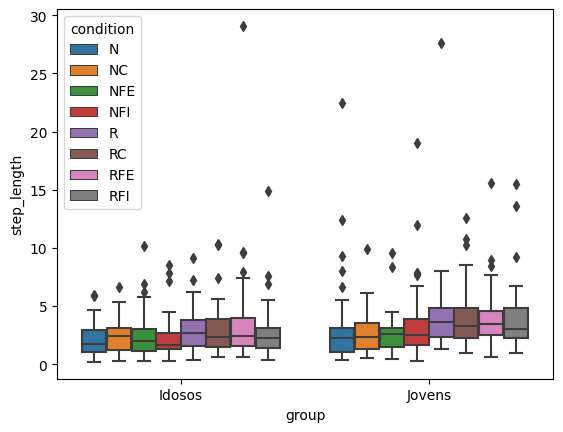

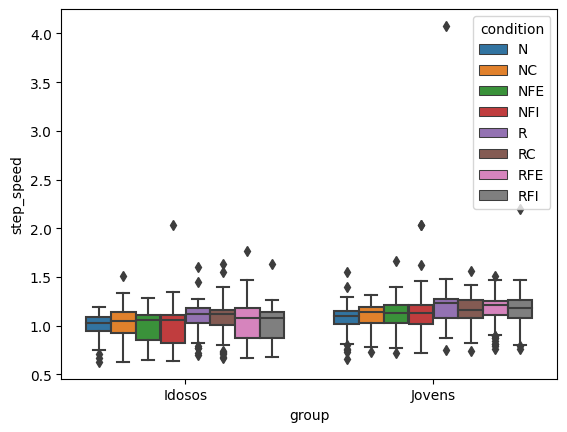

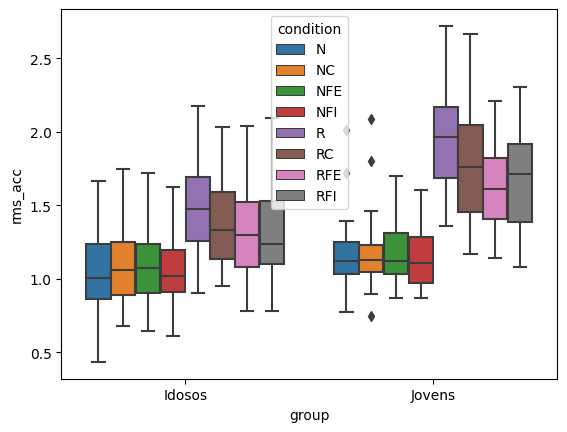

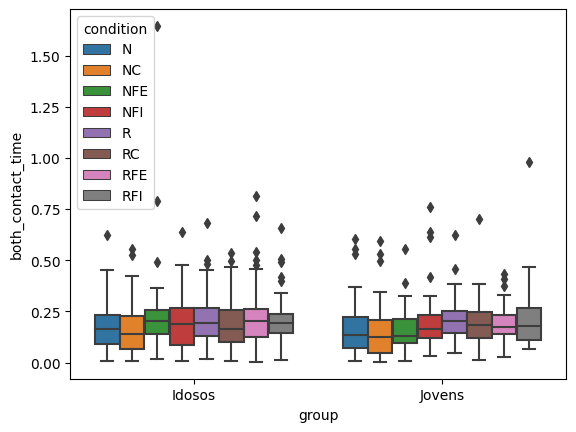

In [ ]:
vars = results.columns[3:]
for v in vars:
  plt.figure()
  ax = sns.boxplot(x='group', hue = 'condition', y=v, data=results)
  plt.savefig(plots_folder+v+'.png')

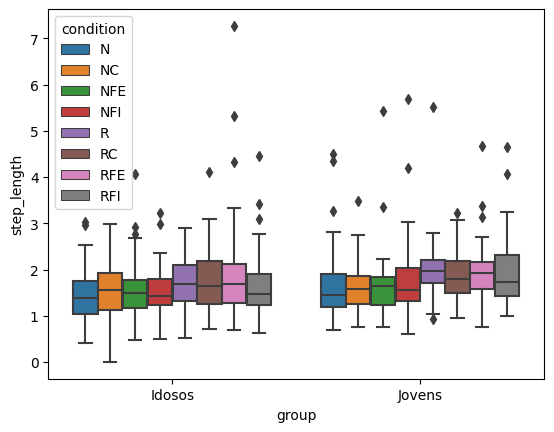

<Figure size 640x480 with 0 Axes>

In [ ]:
ax = sns.boxplot(x='group', hue = 'condition', y='step_length', data=results)
plt.savefig(plots_folder+'step_length.png')

In [ ]:
for err in errors:
  g,cond,part,f = err
  T = pd.read_excel(f)
  cols = find_columns(T)
  cols_acc = find_columns_acc(T)

  t = T.iloc[:,0].to_numpy()
  dt = np.mean(np.diff(t))

  peE = T.iloc[:,cols[:3]].to_numpy()
  peD = T.iloc[:,cols[6:9]].to_numpy()

  mpeE = np.linalg.norm(peE,axis=1)
  mpeD = np.linalg.norm(peD,axis=1)

  peaks,_ = sgn.find_peaks(mpeD,height=0.65*np.max(mpeE),distance=10)


  plt.plot(t,mpeD)
  plt.plot(t[peaks],mpeD[peaks],'r+')
  plt.savefig(folder+'grupo_'+g+'_cond_'+cond+'_part_'+part+'.png')
  plt.clf()

In [ ]:
 np.mean(np.diff(t))

0.007499999999999987

In [ ]:
np.max(mpeE)

9.28986539115745

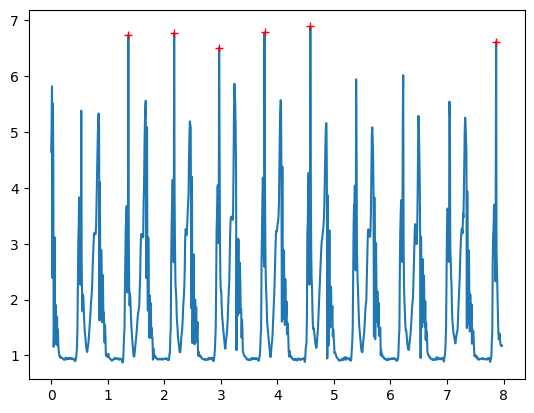

In [ ]:
plt.plot(t,mpeD)
plt.plot(t[peaks],mpeD[peaks],'r+')

In [ ]:
peaks

array([], dtype=int64)

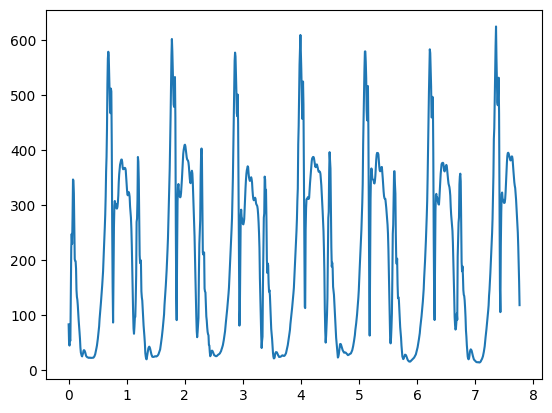

In [ ]:
#plt.plot(t,mpeE)
plt.plot(t,mpeD)

(1036,)

In [ ]:
np.linalg.norm(peE,axis=1)

array([170.35961876, 188.37410374, 220.39590558, ...,   0.        ,
       182.52650045, 163.01722463])